In [ ]:
import numpy as np
import sklearn.datasets
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

In [ ]:
def V_1(X):
    n = X.shape[0]

    X = np.sort(X)
    s = np.std(X)

    tmp_1 = True
    tmp_2 = True

    V_array = np.array([])


    for m in range(1, int(n/2)):

        product = 1


        for i in range(1, n + 1):

            if i - m <= 1:
                X_1 = X[0]
                tmp_1 = False

            if i + m >= n:
                X_2 = X[-1]
                tmp_2 = False


            if tmp_1:
                X_1 = X[i - m - 1]

            if tmp_2:
                X_2 = X[i + m - 1]

            tmp_1 = True
            tmp_2 = True

            product *= 1 / (X_2 - X_1)


        V = (2 * np.pi * np.e * s**2)**(n / 2) * (2 * m / n) ** n * product

        V_array = np.append(V_array, V)


    return V_array

In [ ]:
def calculate_inner_product(X, m):
    n = X.shape[0]
    p = 1
    for i in range(n):
        i_plus_m = min(i + m, n - 1)
        i_minus_m = max(i - m, 0)
        p /= (X[i_plus_m] - X[i_minus_m])
    return p * (2 * m / n) ** n

def V_2(X, delta=0.5):
    n = X.shape[0]
    X = np.sort(X)
    s = np.std(X)
    V = np.array([calculate_inner_product(X, m) for m in range(1, int(n ** (1 - delta)))])

    return (2 * np.pi * np.e * s**2)**(n / 2) * V



In [ ]:
def get_c_array(alpha, n_array, N, test=V_1):
    C_array = np.array([])
    for n in tqdm(n_array):
        V_array = np.array([])
        X = np.random.normal(0, 1, size=(N, n))

        for i in range(N):
            V = np.log(np.min(test(X[i])))
            V_array = np.append(V_array, V)

        V_array = np.sort(V_array)
        C = V_array[-int(alpha * N) + 2]
        C_array = np.append(C_array, C)

    return C_array

In [ ]:
N = 1000 # number of samples for monte carlo
n_array = np.arange(5, 100, 5, dtype=int) # sample size
alphas = [0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.3, 0.4, 0.45]

In [ ]:
C_arrays_v1 = np.array([get_c_array(alpha, n_array, N, test=V_1) for alpha in alphas]) # array of thresholds for V1 test

100%|██████████| 19/19 [00:27<00:00,  1.42s/it]


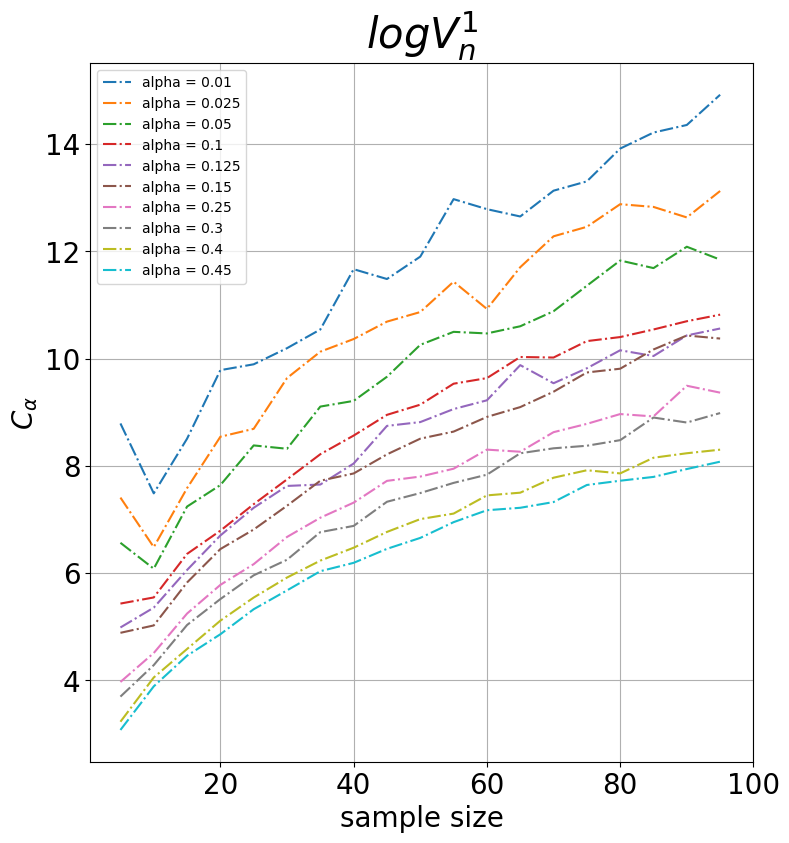

In [153]:
f, ax1 = plt.subplots(1,figsize = (8,8))

# colors = ['black', 'blue'] * 5
# colors[0] = 'red'

for i, C_array in enumerate(C_arrays_v1):
    plt.plot(n_array, C_array, label='alpha = '+str(alphas[i]), ls='dashdot')#, color=colors[i])

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('sample size', fontsize = 20)
ax1.set_ylabel(r'$C_{\alpha}$', fontsize = 20)

ax1.legend(fontsize = 10)
ax1.set_xticks(np.arange(20, 101, 20), np.arange(20, 101, 20))
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

plt.tight_layout()

plt.title('$logV_n^1$', fontsize = 30)
plt.show()

In [ ]:
C_arrays_v2 = np.array([get_c_array(alpha, n_array, N, test=V_2) for alpha in alphas]) # array of thresholds for V2 test

100%|██████████| 19/19 [00:06<00:00,  3.07it/s]


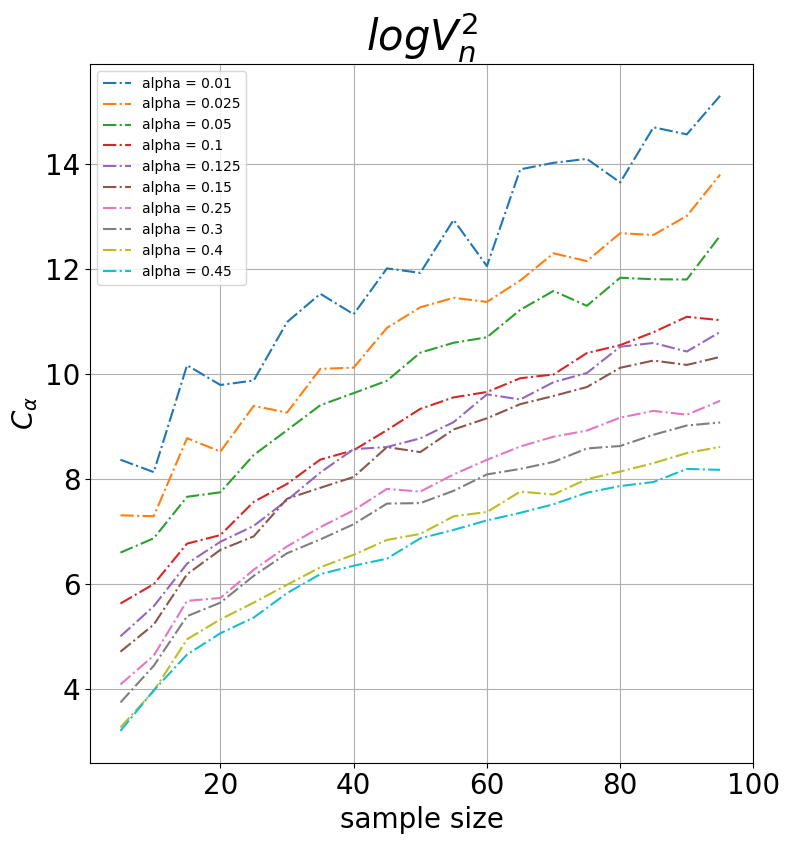

In [154]:
f, ax1 = plt.subplots(1,figsize = (8,8))

# colors = ['black', 'blue'] * 5
# colors[0] = 'red'

for i, C_array in enumerate(C_arrays_v2):
    plt.plot(n_array, C_array, label='alpha = '+str(alphas[i]), ls='dashdot')#, color=colors[i])


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('sample size', fontsize = 20 )
ax1.set_ylabel(r'$C_{\alpha}$', fontsize = 20 )


ax1.legend(fontsize = 10)

ax1.set_xticks(np.arange(20, 101, 20), np.arange(20, 101, 20))
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

plt.tight_layout()

plt.title('$logV_n^2$', fontsize = 30)
plt.show()


### Explore power of the test

In [ ]:
indexes = [3, 9, 13]
alpha_index= 2
n_array[indexes], alphas[alpha_index]

(array([20, 50, 70]), 0.05)

In [ ]:
C20, C50, C70 = np.exp(C_arrays_v1[alpha_index][indexes]) # thresholds for statistics
C_dict_V1 = {20: C20, 50: C50, 70: C70}
C20, C50, C70 = np.exp(C_arrays_v2[alpha_index][indexes]) # thresholds for statistics
C_dict_V2 = {20: C20, 50: C50, 70: C70}

In [ ]:
from collections import defaultdict
from scipy.stats import shapiro
import pandas as pd

In [ ]:
v1_pows = defaultdict(list)
v2_pows = defaultdict(list)
w_pows = defaultdict(list)
Ts_pows = [defaultdict(list) for m in range(11)]

In [ ]:
distrs = {
    'Exp': [np.random.exponential, [1]],
    'Gamma': [np.random.gamma, [2, 1]],
    'Unif': [np.random.uniform, [0, 1]],
    'Beta': [np.random.beta, [2, 1]],
    'Cauchy': [np.random.standard_cauchy, []],
    }

In [ ]:
def calculate_Tm(X, m):
    n = X.shape[0]
    X = np.sort(X)
    s = np.std(X)
    p = np.float128(1)
    for i in range(n):
        i_plus_m = min(i + m, n - 1)
        i_minus_m = max(i - m, 0)
        p /= (X[i_plus_m] - X[i_minus_m])
    return (2 * np.pi * np.e * s**2)**(n / 2) * p * (2 * m / n) ** n

In [ ]:
sample_sizes = [20, 50, 70]
Ts_dict = {key: {} for key in sample_sizes}
alpha = 0.05
N = 1000
for sample_size in sample_sizes:
  for m in tqdm(list(range(1, 11)) + [sample_size]):
    X = np.random.normal(0, 1, size=(N, sample_size))
    Ts = sorted([calculate_Tm(X[i], m) for i in range(N)])
    Ts_dict[sample_size][m] = (Ts[-int(alpha * N)])


100%|██████████| 11/11 [00:01<00:00,  9.46it/s]


In [ ]:
n_mc = 1000
for key in tqdm(distrs.keys()):
    for sample_size in [20, 50, 70]:
        func, params = distrs[key]
        samples = func(*params, (n_mc, sample_size))
        pow_v1 = (np.array([(V_1(samples[i]) < C_dict_V1[sample_size]).sum() / sample_size for i in range(n_mc)]) < 0.05).sum() / n_mc
        pow_v2 = (np.array([(V_2(samples[i]) < C_dict_V2[sample_size]).sum() / sample_size for i in range(n_mc)]) < 0.05).sum() / n_mc
        pow_shapiro = (np.array([shapiro(samples[i]).pvalue for i in range(n_mc)]) < 0.05).sum() / n_mc
        # calculate Ts:
        for j, m in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, sample_size]):
          Ts_pows[j][key].append((np.array([(calculate_Tm(samples[i], m) < Ts_dict[sample_size][m]).sum() / sample_size for i in range(n_mc)]) < 0.05).sum() / n_mc)
        v1_pows[key].append(pow_v1)
        v2_pows[key].append(pow_v2)
        w_pows[key].append(pow_shapiro)

 80%|████████  | 4/5 [00:36<00:08,  8.89s/it]<ipython-input-12-802366c9a342>:41: RuntimeWarning: overflow encountered in double_scalars
  V = (2 * np.pi * np.e * s**2)**(n / 2) * (2 * m / n) ** n * product
<ipython-input-13-0dee9c5a86c1>:16: RuntimeWarning: overflow encountered in double_scalars
  return (2 * np.pi * np.e * s**2)**(n / 2) * V
<ipython-input-137-7efc57b10717>:10: RuntimeWarning: overflow encountered in double_scalars
  return (2 * np.pi * np.e * s**2)**(n / 2) * p * (2 * m / n) ** n
100%|██████████| 5/5 [00:43<00:00,  8.70s/it]


In [ ]:
dfs = {key: pd.DataFrame(columns=[f'T{m}' for m in range(1, 11)] + [f'T{key}'] + ['V1', 'V2', 'W']) for key in [20, 50, 70]}
for i, key in enumerate([20, 50, 70]):
    dfs[key]['V1'] = pd.DataFrame(v1_pows).iloc[i]
    dfs[key]['V2'] = pd.DataFrame(v2_pows).iloc[i]
    dfs[key]['W'] = pd.DataFrame(w_pows).iloc[i]
    for j, m in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, key]):
      dfs[key][f'T{m}'] = pd.DataFrame(Ts_pows[j]).iloc[i]

In [ ]:
dfs[20]

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T20,V1,V2,W
Exp,0.680,0.779,0.835,0.813,0.830,0.821,0.786,0.750,0.742,0.654,0.122,0.835,0.840,0.839
Gamma,0.278,0.398,0.466,0.429,0.463,0.447,0.391,0.347,0.342,0.280,0.091,0.462,0.471,0.509
Unif,0.315,0.380,0.435,0.393,0.465,0.477,0.426,0.390,0.461,0.403,0.529,0.426,0.441,0.196
Beta,0.296,0.387,0.447,0.415,0.474,0.470,0.423,0.406,0.437,0.365,0.318,0.443,0.449,0.293
Cauchy,0.740,0.770,0.753,0.690,0.629,0.563,0.480,0.427,0.407,0.384,0.000,0.527,0.758,0.871


In [ ]:
dfs[50]

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T50,V1,V2,W
Exp,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000
Gamma,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.925,0.922,0.950
Unif,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.961,0.953,0.772
Beta,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.957,0.956,0.850
Cauchy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.419,0.983,0.991


In [ ]:
dfs[70]

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T70,V1,V2,W
Exp,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000
Gamma,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.987,0.983,0.993
Unif,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.998,0.995,0.947
Beta,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999,0.996,0.973
Cauchy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.367,1.000,1.000
